**[SNE-01]** モジュールをインポートして、乱数のシードを設定します。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series

np.random.seed(20160614)
tf.set_random_seed(20160614)

**[SNE-02]** トレーニングセットのデータを生成します。

In [2]:
def generate_datablock(n, mu, var, t):
    data = multivariate_normal(mu, np.eye(2)*var, n)
    df = DataFrame(data, columns=['x1','x2'])
    df['t'] = t
    return df

df0 = generate_datablock(15, [7,7], 22, 0)
df1 = generate_datablock(15, [22,7], 22, 0)
df2 = generate_datablock(10, [7,22], 22, 0)
df3 = generate_datablock(25, [20,20], 22, 1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

**[SNE-03]** (x1, x2) と t を別々に集めたものをNumPyのarrayオブジェクトとして取り出しておきます。

In [3]:
train_x = train_set[['x1','x2']].values
train_t = train_set['t'].values.reshape([len(train_set), 1])

**[SNE-04]** 単層ネットワークによる二項分類器のモデルを定義。隠れ層のノードを４個に増やした。

In [4]:
num_units = 4
mult = train_x.flatten().mean()

x = tf.placeholder(tf.float32, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, num_units]))
b1 = tf.Variable(tf.zeros([num_units]))
hidden1 = tf.nn.tanh(tf.matmul(x, w1) + b1*mult)

w0 = tf.Variable(tf.zeros([num_units, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden1, w0) + b0*mult)

**[SNE-05]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義。学習率を0.0005に変更。

In [5]:
t = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.GradientDescentOptimizer(0.0005).minimize(loss)
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[SNE-06]** セッションを用意して、Variableを初期化します。

In [6]:
### >>> with GPU 80%
#gpuConfig = tf.ConfigProto(
#    gpu_options = tf.GPUOptions(
#        per_process_gpu_memory_fraction = 0.8),
#    device_count = {'GPU':0})
#sess = tf.Session(config = gpuConfig)
### <<<
#
### >>> with CPU only
sess = tf.Session()
### <<<
sess.run(tf.global_variables_initializer())

**[SNE-07]** パラメーターの最適化を4000回繰り返します。

In [7]:
i = 0
for _ in range(4000):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    if i % 100 == 0:
        loss_val, acc_val = sess.run(
            [loss, accuracy], feed_dict={x:train_x, t:train_t})
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 100, Loss: 42.306728, Accuracy: 0.615385
Step: 200, Loss: 35.429840, Accuracy: 0.615385
Step: 300, Loss: 29.520409, Accuracy: 0.830769
Step: 400, Loss: 23.003906, Accuracy: 0.892308
Step: 500, Loss: 17.963091, Accuracy: 0.938462
Step: 600, Loss: 14.951678, Accuracy: 0.938462
Step: 700, Loss: 12.873037, Accuracy: 0.938462
Step: 800, Loss: 11.512376, Accuracy: 0.953846
Step: 900, Loss: 10.482064, Accuracy: 0.969231
Step: 1000, Loss: 10.217467, Accuracy: 0.969231
Step: 1100, Loss: 9.669033, Accuracy: 0.969231
Step: 1200, Loss: 9.234619, Accuracy: 0.969231
Step: 1300, Loss: 8.777385, Accuracy: 0.969231
Step: 1400, Loss: 8.194551, Accuracy: 0.969231
Step: 1500, Loss: 7.599588, Accuracy: 0.969231
Step: 1600, Loss: 7.097384, Accuracy: 0.969231
Step: 1700, Loss: 6.634112, Accuracy: 0.969231
Step: 1800, Loss: 6.177128, Accuracy: 0.984615
Step: 1900, Loss: 5.825530, Accuracy: 0.984615
Step: 2000, Loss: 5.583846, Accuracy: 0.984615
Step: 2100, Loss: 5.404093, Accuracy: 0.984615
Step: 2200, 

**[SNE-08]** 得られた確率を色の濃淡で図示します。

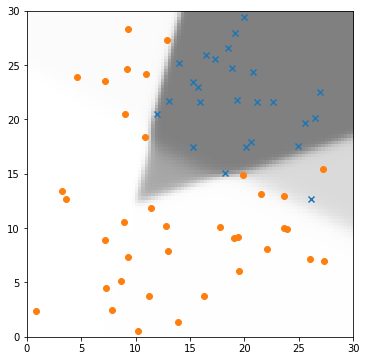

In [8]:
train_set1 = train_set[train_set['t']==1]
train_set2 = train_set[train_set['t']==0]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_xlim([0,30])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = []
for x2 in np.linspace(0,30,100):
    for x1 in np.linspace(0,30,100):
        locations.append((x1,x2))
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100,100))
subplot.imshow(p_vals, origin='lower', extent=(0,30,0,30),
               cmap=plt.cm.gray_r, alpha=0.5)